In [142]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))

In [143]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from utils import get_channel
from CustomTransformers import TimeSeriesFreqRegularization
from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


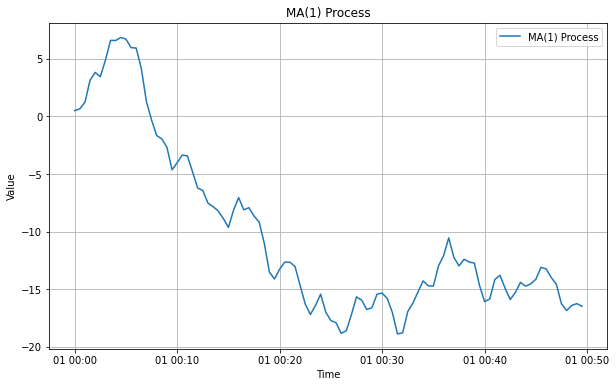

In [144]:
channel_name = 'value'
# MA(1) parameters
ma = np.array([1, 0.6])
ar = np.array([1])  # no AR part

np.random.seed(42)
n = 100
# Generate stationary MA(1)
ma1_sample = arma_generate_sample(ar, ma, nsample=n)
# Make it non-stationary by cumulative sum
non_stationary_series = np.cumsum(ma1_sample)
non_stationary_series = pd.Series(non_stationary_series)    

df = pd.DataFrame(non_stationary_series, columns=['value'])
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='30s')
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['value'], label='MA(1) Process')
plt.title('MA(1) Process')
plt.xlabel('Time')  
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [145]:
tsr = TimeSeriesFreqRegularization(columns=[channel_name])
tsr.fit(df)
print(f"Frecuencia: {tsr.most_frequent_frequency_}s")
ldf = tsr.transform(df)


Frecuencia: 30s


In [146]:
ADF_result = adfuller(ldf[channel_name])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.3853337219488093
p-value: 0.5892867711237366


No, no es estacionaria, ya que el p-valor es mayor que 0.05.

In [147]:
ldf.loc[:,['values_diff']] = ldf[channel_name].diff()
df_diff1 = ldf.copy()
df_diff1.dropna(inplace=True)

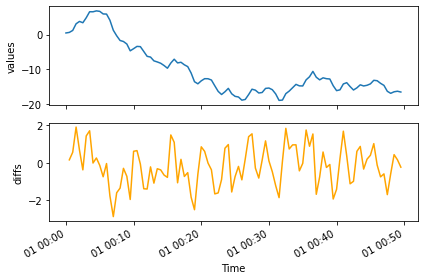

In [148]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf[channel_name])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Moving average de orden 1

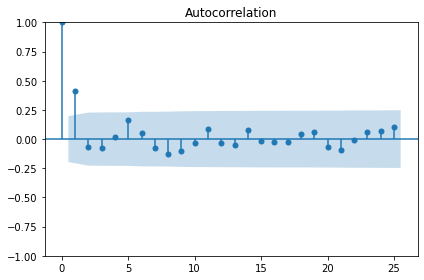

In [149]:
plot_acf(df_diff1["values_diff"], lags=25)
plt.tight_layout()
plt.show()
#MA(22)?

Dividimos en entrenamiento y test

In [150]:
train_percent = 0.8
train = df_diff1[["values_diff"]][:int(train_percent*len(df_diff1))]
test = df_diff1[["values_diff"]][int((train_percent)*len(df_diff1)):]
print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")

Train set length: 79
Test set length: 20


Aplicamos métodos ingenuos de pronostico junto con moving average

In [151]:
TRAIN_LEN   = len(train)
HORIZON     = len(test)
WINDOW      = 1
ORDER       = 1  # AR(1)

pred_mean       = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'mean', order=ORDER)
pred_last_value = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'last', order=ORDER)
pred_MA         = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'MA', order=ORDER)

test['pred_mean']       = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_MA']         = pred_MA

Vemos cual da mejor...

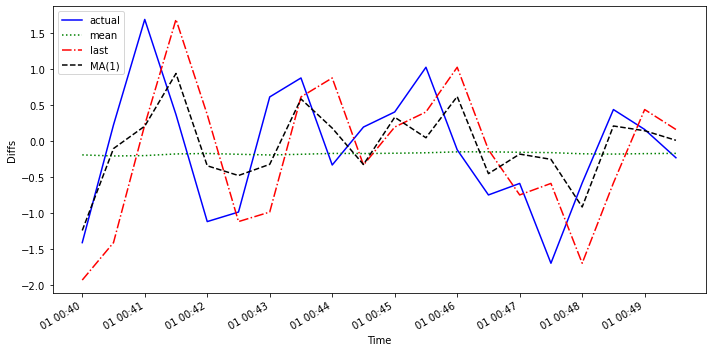

In [152]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_MA'], 'k--', label='MA(1)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

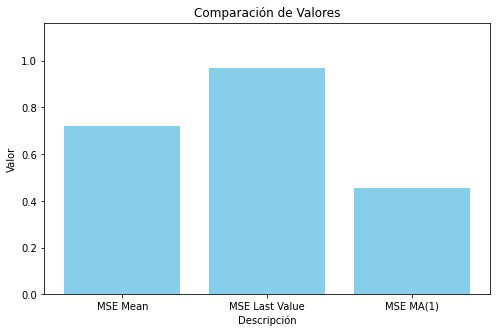

In [153]:
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_MA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', 'MSE MA(1)'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))
plt.bar(df_comm['Descripción'], df_comm['Valor'], color='skyblue')

plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

Agrego las predicciones al dataset y luego acumulo para hacer "la integral"

In [154]:
df_diff1.loc[test.index, ["Predicted_diffs"]] = test["pred_MA"]
df_diff1["Predicted_serie"] = df_diff1.loc[:, channel_name][len(train)]+test['pred_MA'].cumsum()

Cotejo los resultados en la escala correcta

In [155]:
df_diff1.loc[test.index, ["Predicted_diffs"]] = test["pred_MA"]

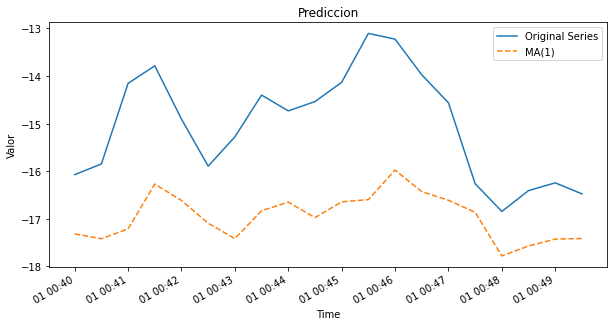

In [156]:
df_pred = df_diff1.loc[test.index,:]
plt.figure(figsize=(10, 5))
plt.plot(df_pred.index, df_pred[channel_name], label='Original Series')
plt.plot(df_pred.index, df_pred["Predicted_serie"], label='MA(1)', linestyle='--')
plt.title("Prediccion")
plt.xlabel("Time")      
plt.ylabel("Valor")
plt.gcf().autofmt_xdate()   
plt.legend()
plt.show()
